# CAPSTONE - Grade Predictions for A Level H2 Math
IMPORTANT NOTE: You may run this notebook but the results will change as only 500 rows of data for each batch is shared due to confidentiality.

---
# (3) Modelling
We use the 62 columns (including one-hot encoded ones) from the previous notebook on [Data Cleaning and EDA](2_Data_Cleaning_and_EDA.ipynb) as features and the targets from the [Benchmark](3_Benchmark.ipynb) notebook. All model building is performed using only batch 18 and batch 19 data as the final labels for batch 20 only became available near the end of this project, so batch 20 could not be used for supervised learning.

We first calculate the baseline scores based on the metrics discussed in the [Introduction](0_Introduction.ipynb) notebook but keep in mind that we have a set of benchmark scores from the [Benchmark](3_Benchmark.ipynb) notebook to compare against as well.

As predicting the lowest grade category is important, and this grade category also happens to be a very small minority class, we will focus on classifiers with a class weights hyperparameter. We also attempt XG Boost classifier, which is known for performing well in Kaggle competitions, and a new approach to ordinal classification based on [this paper](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf) that claims to give better results when the classes are ordinal in nature, i.e. have inherent ranking between them.

Insights are gleaned from our machine learning models through the feature coefficients or importances, such as which features positively or negatively impact a student's chances of getting the highest or lowest grade category. 

Finally, we build our best possible model by training it on the combined datasets for batch 18 and batch 19. We evaluate the predictions for batch 20 and compare the results in detail with the benchmark predictions.

We assess whether our 3 objectives mentioned in the [Introduction](0_Introduction.ipynb) notebook are met in the next notebook on [Conclusion and Recommendations](4_Conclusion_and_Recommendations.ipynb).

## Contents:
- [Baseline](#Baseline)
- [Preprocessing](#Preprocessing)
- [Algorithm Selection](#Algorithm-Selection)
- [Tuning Logistic Regression](#Tuning-Logistic-Regression)
- [XGBoost](#XGBoost)
- [Top Features](#Top-Features)
- [Selecting Features for Modelling](#Selecting-Features-for-Modelling)
- [New Approach to Ordinal Classification](#New-Approach-to-Ordinal-Classification)
- [Evaluating Final Model](#Evaluating-Final-Model)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from xgboost import XGBClassifier

from sklearn.metrics import cohen_kappa_score, recall_score, confusion_matrix

# set parameters for plots
plt.rcParams['figure.figsize'] = [16,8]
plt.style.use('fivethirtyeight')

In [2]:
# import data
# targets
y_18 = pd.read_csv('../data_cleaned/y_18.csv', index_col='NEWID')
y_19 = pd.read_csv('../data_cleaned/y_19.csv', index_col='NEWID')
y_20 = pd.read_csv('../data_cleaned/y_20.csv', index_col='NEWID')

y_18_target = y_18['MA2'].values
y_19_target = y_19['MA2'].values
y_20_target = y_20['MA2'].values

# features
Features_18 = pd.read_csv('../data_cleaned/Features_18.csv', index_col='NEWID')
Features_19 = pd.read_csv('../data_cleaned/Features_19.csv', index_col='NEWID')
Features_20 = pd.read_csv('../data_cleaned/Features_20.csv', index_col='NEWID')

# check dataframes
print(' Batch 18 '.center(30, "="))
display(y_18.head(2))
display(Features_18.head(2))
print('\n\n')

print(' Batch 19 '.center(30, "="))
display(y_19.head(2))
display(Features_19.head(2))
print('\n\n')

print(' Batch 20 '.center(30, "="))
display(y_20.head(2))
display(Features_20.head(2))

========== Batch 18 ==========


,MA2
NEWID,
20180001,0
20180002,0


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,PTS_Sec4,AM,EM,CIP HOURS,CCA President,CCA Sec-Treas,CCA Role,CT Rep,CIP Leader,CIP Organiser
NEWID,,,,,,,,,,,,,,,,,,,,,
20180001,0,1,0,0,1,0,0,0,0,0,...,0.235309,1,1,13.8,0.0,0.0,0.0,0.0,0.0,0.0
20180002,1,0,0,0,0,0,1,0,0,0,...,-0.827665,1,1,40.0,0.0,0.0,0.0,0.0,0.0,0.0





========== Batch 19 ==========


,MA2
NEWID,
20190001,1
20190002,0


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,PTS_Sec4,AM,EM,CIP HOURS,CCA President,CCA Sec-Treas,CCA Role,CT Rep,CIP Leader,CIP Organiser
NEWID,,,,,,,,,,,,,,,,,,,,,
20190001,0,1,0,1,0,0,0,0,1,0,...,4.284206,1,1,6.0,0.0,0.0,0.0,0.0,0.0,0.0
20190002,0,1,0,0,1,0,0,0,0,0,...,-0.465438,1,1,41.0,0.0,0.0,0.0,0.0,0.0,0.0





========== Batch 20 ==========


,MA2
NEWID,
20200001,0
20200002,0


,GENDER_F,GENDER_M,INTAKE_DSA,INTAKE_DSA (CCA),INTAKE_IP (X),INTAKE_IP (Y),INTAKE_JAE Ordinary Admission,SEC SCHOOL_BUKIT PANJANG GOVT. HIGH SCHOOL,SEC SCHOOL_CATHOLIC HIGH SCHOOL,SEC SCHOOL_CHIJ ST. NICHOLAS GIRLS' SCHOOL,...,PTS_Sec4,AM,EM,CIP HOURS,CCA President,CCA Sec-Treas,CCA Role,CT Rep,CIP Leader,CIP Organiser
NEWID,,,,,,,,,,,,,,,,,,,,,
20200001,1,0,0,0,0,0,1,0,0,0,...,-0.218251,1,1,38.5,1.0,0.0,0.0,0.0,0.0,1.0
20200002,1,0,0,0,0,1,0,0,0,0,...,-0.632111,1,1,34.5,0.0,0.0,1.0,0.0,0.0,1.0


# Baseline

In [3]:
#CELL NOT RUN due to confidentiality
# # proportions in targets
# print(' Batch 18 '.center(30, "="))
# print(y_18.value_counts(normalize=True).sort_index())
# print()

# print(' Batch 19 '.center(30, "="))
# print(y_19.value_counts(normalize=True).sort_index())

In [4]:
# define functions to evaluate predictions

def get_scores(y_true, y_pred, descr):
    """Display and return dataframe of evaluation metrics"""
    cohen_kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    ESU_recall = recall_score(y_true, y_pred, average=None)[-1]
    macro_recall = recall_score(y_true, y_pred, average='macro')
    num_ESU = sum(1 if pred == 4  else 0 for pred in y_pred)
    
    df = pd.DataFrame([np.round([cohen_kappa, ESU_recall, macro_recall, num_ESU], 4)],
                      columns=["Weighted Cohen's Kappa", 
                               "Recall for ESU", 
                               "Macro Average Recall", 
                               "Number Predicted as ESU"],
                      index = [descr]
                     )
    return df

# eval_pred NOT USED due to confidentiality
def eval_pred(y_true, y_pred, descr):
    """Display confusion matrix, number of predictions for each grade and evaluation metrics"""
    df = get_scores(y_true, y_pred, descr)
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred),
                      columns=['A','B','C','D','ESU'], 
                      index=['A','B','C','D','ESU'])
    cm.index.rename('Actual\Predicted',inplace=True)
    display(cm)
    print()
    display(pd.DataFrame([pd.Series(y_true, name='Actual').value_counts().sort_index(),
                          pd.Series(y_pred, name='Prediction').value_counts().sort_index()],
                         dtype='int'
                        ).rename(columns={0:'A', 1:'B', 2:'C', 3:'D', 4:'ESU'}))
    return df

In [5]:
# get_scores used instead of eval_pred due to confidentiality
# baseline scores
df_1 = get_scores(y_18_target, [0]*len(y_18), 18)
df_2 = get_scores(y_19_target, [0]*len(y_19), 19)
pd.concat([df_1, df_2])

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
18,0.0,0.0,0.2,0.0
19,0.0,0.0,0.2,0.0


Our models should be better than the baseline scores above, but we also have another set of benchmark scores to compare with, as seen in the [Benchmark](1_Benchmark.ipynb) notebook, quoted below for reference.

|Batch|Weighted Cohen's Kappa|Recall for ESU|Macro Average Recall|Number Predicted as ESU|
|---|---|---|---|---|
|18|0.7581|1.0|0.5729|19.0|
|19|0.7204|1.0|0.5099|38.0|

# Preprocessing
## Standard Scaling

In [6]:
# check numeric features mean and standard deviation
numeric_features = ['MA2', 'PTS', 'NO OF CCA', 'GP/KI','H1', 'H3', 'GP/KI_C1', 'MA2_C1', 
                    'H1_C1', 'PTS_C1', 'PTS_Sec4', 'AM', 'EM', 'CIP HOURS']

print(' Batch 18 '.center(30, "="))
display(Features_18[numeric_features].agg(['mean', 'std']).round(2))
print('\n\n')
print(' Batch 19 '.center(30, "="))
display(Features_19[numeric_features].agg(['mean', 'std']).round(2))
print('\n\n')
print(' Batch 20 '.center(30, "="))
display(Features_20[numeric_features].agg(['mean', 'std']).round(2))
print('\n\n')

========== Batch 18 ==========


,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1,PTS_Sec4,AM,EM,CIP HOURS
mean,62.35,73.40,1.18,2.75,0.40,4.62,3.49,55.11,0.30,58.45,-0.0,1.63,1.17,84.56
std,13.89,14.18,0.44,1.07,1.06,1.01,1.24,14.24,1.03,15.20,1.0,1.14,0.49,62.48





========== Batch 19 ==========


,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1,PTS_Sec4,AM,EM,CIP HOURS
mean,60.81,73.47,1.20,2.38,0.41,4.35,3.36,54.59,0.31,59.87,-0.0,1.47,1.28,56.64
std,15.47,14.69,0.45,0.98,1.22,1.29,1.20,15.21,1.14,14.79,1.0,1.00,0.70,55.30





========== Batch 20 ==========


,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1,PTS_Sec4,AM,EM,CIP HOURS
mean,61.07,73.23,1.14,2.18,0.28,4.44,2.90,63.00,0.17,64.35,-0.0,1.39,1.27,49.21
std,16.42,16.49,0.40,0.95,1.09,1.18,1.03,15.57,0.82,14.46,1.0,0.92,0.72,49.39


In [7]:
# apply standard scaling to all features except those that only take values of 0 or 1
sc = StandardScaler()
ct = make_column_transformer((sc, numeric_features),
                             remainder="passthrough",
                             verbose_feature_names_out=False)

Features_18 = pd.DataFrame(ct.fit_transform(Features_18), columns=ct.get_feature_names_out())
Features_19 = pd.DataFrame(ct.fit_transform(Features_19), columns=ct.get_feature_names_out())
Features_20 = pd.DataFrame(ct.fit_transform(Features_20), columns=ct.get_feature_names_out(), index=Features_20.index)

# check numeric features mean and standard deviation again
# mean should be close to 0 and standard deviation close to 1
print(' Batch 18 '.center(30, "="))
display(Features_18[numeric_features].agg(['mean', 'std']).round(2))
print('\n\n')
print(' Batch 19 '.center(30, "="))
display(Features_19[numeric_features].agg(['mean', 'std']).round(2))
print('\n\n')
print(' Batch 20 '.center(30, "="))
display(Features_20[numeric_features].agg(['mean', 'std']).round(2))

========== Batch 18 ==========


,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1,PTS_Sec4,AM,EM,CIP HOURS
mean,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0





========== Batch 19 ==========


,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1,PTS_Sec4,AM,EM,CIP HOURS
mean,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0





========== Batch 20 ==========


,MA2,PTS,NO OF CCA,GP/KI,H1,H3,GP/KI_C1,MA2_C1,H1_C1,PTS_C1,PTS_Sec4,AM,EM,CIP HOURS
mean,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Algorithm Selection
As we wish to improve the recall rate for ESU, we focus on algorithms that allow us to adjust a hyperparameter for class weights. We attempt 3 versions with each algorithm, without using class weights, using 'balanced' class weights and the third with the class weight of 'ESU' set to 1000 times higher than the others.

We will try Logistic Regression, Support Vectors, Random Forest, Extra Trees to see which algorithm gives a better result before working to tune the selected algorithm(s), including the class weights hyperparameter.

We will score the models on the 3 metrics discussed in the [Introduction](0_Introduction.ipynb) notebook, namely weighted Cohen's kappa, recall for ESU and macro average recall. We evaluate each model by fitting it to one batch's features and predicting the other batch's A level grades, as we are concerned with how well our final model will perform when applied to a future batch.

In [8]:
def fit_models(clf, features):
    """Fit models on Batch 18 data and Batch 19 data"""
    model_1 = clone(clf)
    model_1.fit(Features_18[features], y_18_target)
    
    model_2 = clone(clf)
    model_2.fit(Features_19[features], y_19_target)

    return model_1, model_2
    
def score_model(clf, features):
    """Score model for Train Scores on both batches and Test Scores when model is applied to other batch"""
    model_1, model_2 = fit_models(clf, features)
    
    pred_1_train = model_1.predict(Features_18[features])
    pred_1_test = model_1.predict(Features_19[features])
    pred_2_train = model_2.predict(Features_19[features])  
    pred_2_test = model_2.predict(Features_18[features])

#HIDDEN due to confidentiality
#     print(' Model 1 on Test Data '.center(40, "="))
#     display(pd.DataFrame([pd.Series(y_19_target, name='Actual').value_counts().sort_index(),
#                       pd.Series(pred_1_test, name='Prediction').value_counts().sort_index()],
#                      dtype='int'
#                     ).rename(columns={0:'A', 1:'B', 2:'C', 3:'D', 4:'ESU'}))
#     print()
#     print(' Model 2 on Test Data '.center(40, "="))
#     display(pd.DataFrame([pd.Series(y_18_target, name='Actual').value_counts().sort_index(),
#                       pd.Series(pred_2_test, name='Prediction').value_counts().sort_index()],
#                      dtype='int'
#                     ).rename(columns={0:'A', 1:'B', 2:'C', 3:'D', 4:'ESU'}))

    df = pd.concat([get_scores(y_18_target, pred_1_train, 'Model 1 Train Scores'),
                    get_scores(y_19_target, pred_1_test, 'Model 1 Test Scores'),
                    get_scores(y_19_target, pred_2_train, 'Model 2 Train Scores'),
                    get_scores(y_18_target, pred_2_test, 'Model 2 Test Scores'),
                   ])
    df.loc['Mean Test Scores'] = np.round(df.iloc[1::2,:].mean(), 4)
    return df

## Logistic Regression
Logistic Regression has the advantage of interpretable coefficients, thus will be our preferred algorithm if the results are close to or better than the other algorithms.

The scores generally improved after using class weights. With 'balanced' class weights, the Weighted Cohen's Kappa is higher, but when the class weight for 'ESU' is set to 1000 times higher, the Recall for ESU and Macro Average Recall improved significantly. This is because the number of rows predicted as 'ESU' increased many times to 19 for Model 1 and 33 for Model 2. These Recall scores are very promising as only a manageable number of students are highlighted as requiring special attention and yet majority of the potential failures were accurately captured.

There is quite a bit of overfitting as the Train Scores are all significantly larger than the Test Scores, which we hope to improve after hyperparameter tuning if this algorithm is selected.

In [9]:
all_features = Features_18.columns
# no class weights
logreg_0 = LogisticRegression(solver='liblinear', random_state=42)
score_model(logreg_0, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7366,0.7143,0.5532,5.0
Model 1 Test Scores,0.5858,0.1250,0.3447,4.0
Model 2 Train Scores,0.6609,0.1250,0.4087,1.0
Model 2 Test Scores,0.5950,0.0000,0.2981,1.0
Mean Test Scores,0.5904,0.0625,0.3214,2.5


In [10]:
# balanced class weights
logreg_1 = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
score_model(logreg_1, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7742,0.8571,0.7566,6.0
Model 1 Test Scores,0.6199,0.1250,0.3886,5.0
Model 2 Train Scores,0.7599,0.7500,0.7127,8.0
Model 2 Test Scores,0.6170,0.0000,0.3648,5.0
Mean Test Scores,0.6184,0.0625,0.3767,5.0


In [11]:
# class weight of 'ESU' set to 1000 times higher
logreg_2 = LogisticRegression(class_weight={0:1, 1:1, 2:1, 3:1, 4:1000}, solver='liblinear', random_state=42)
score_model(logreg_2, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7363,1.0000,0.5928,18.0
Model 1 Test Scores,0.6059,0.3750,0.3600,19.0
Model 2 Train Scores,0.6923,1.0000,0.5556,27.0
Model 2 Test Scores,0.6223,0.8571,0.4537,33.0
Mean Test Scores,0.6141,0.6160,0.4068,26.0


## Support Vectors Classifier
Support Vectors gave poor scores without class weights as none of the rows were predicted as 'ESU'. With 'balanced' class weights, the Recall for ESU was 100% for the Train Scores but still fared poorly for the Test Scores. When class weight for 'ESU' was increased to 1000 times, still only 4 and 3 rows for each model were predicted as 'ESU', which is fewer than the actual numbers. 

The algorithm could perhaps give more decent results after some hyperparameters tuning, but we will go with other algorithms for now.

In [12]:
# no class weights
svc_0 = SVC(random_state=42)
score_model(svc_0, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.8039,0.4286,0.5822,3.0
Model 1 Test Scores,0.6042,0.0000,0.3114,0.0
Model 2 Train Scores,0.6618,0.1250,0.4249,1.0
Model 2 Test Scores,0.5167,0.0000,0.2723,0.0
Mean Test Scores,0.5604,0.0000,0.2918,0.0


In [13]:
# balanced class weights
svc_1 = SVC(class_weight='balanced', random_state=42)
score_model(svc_1, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.8172,1.0000,0.9252,7.0
Model 1 Test Scores,0.6428,0.1250,0.4111,3.0
Model 2 Train Scores,0.7847,1.0000,0.9126,8.0
Model 2 Test Scores,0.6293,0.0000,0.3771,2.0
Mean Test Scores,0.6360,0.0625,0.3941,2.5


In [14]:
# class weight of 'ESU' set to 1000 times higher
svc_2 = SVC(class_weight={0:1, 1:1, 2:1, 3:1, 4:1000}, random_state=42)
score_model(svc_2, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.8275,1.0000,0.6965,7.0
Model 1 Test Scores,0.6006,0.1250,0.3332,4.0
Model 2 Train Scores,0.7412,1.0000,0.5999,8.0
Model 2 Test Scores,0.5281,0.1429,0.2982,3.0
Mean Test Scores,0.5644,0.1340,0.3157,3.5


## Random Forest Classifier
Random Forest gave better Weighted Cohen's Kappa score than Logistic Regression, but the Recall for 'ESU' was very low as the number of rows predicted as 'ESU' only increased ever so slightly from 1 to 3 and 0 to 1 for Model 1 and Model 2 respectively, even after setting class weight of 'ESU' to 1000. It is thus not suitable for our use case, as correctly identifying the 'ESU' group is a key objective.

There is also very serious overfitting as Decision Tree based algorithms tend to overfit without hyperparameter tuning.

In [15]:
# no class weights
rfc_0 = RandomForestClassifier(random_state=42)
score_model(rfc_0, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.6280,0.1250,0.3448,1.0
Model 2 Train Scores,0.9991,1.0000,0.9987,8.0
Model 2 Test Scores,0.6114,0.0000,0.2984,0.0
Mean Test Scores,0.6197,0.0625,0.3216,0.5


In [16]:
# balanced class weights
rfc_1 = RandomForestClassifier(class_weight='balanced', random_state=42)
score_model(rfc_1, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.6304,0.1250,0.3473,3.0
Model 2 Train Scores,0.9991,1.0000,0.9987,8.0
Model 2 Test Scores,0.5674,0.0000,0.2779,0.0
Mean Test Scores,0.5989,0.0625,0.3126,1.5


In [17]:
# class weight of 'ESU' set to 1000 times higher
rfc_2 = RandomForestClassifier(class_weight={0:1, 1:1, 2:1, 3:1, 4:1000}, random_state=42)
score_model(rfc_2, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.6357,0.1250,0.3345,2.0
Model 2 Train Scores,0.9991,1.0000,0.9987,8.0
Model 2 Test Scores,0.6384,0.1429,0.3357,2.0
Mean Test Scores,0.6370,0.1340,0.3351,2.0


## Extra Trees Classifier
Extra Trees did not do as well as Logistic Regression for all scores. Similar to Random Forest, there is very serious overfitting as it is also a Decision Tree based algorithm.

In [18]:
# no class weights
etc_0 = ExtraTreesClassifier(random_state=42)
score_model(etc_0, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.6377,0.1250,0.3394,1.0
Model 2 Train Scores,1.0000,1.0000,1.0000,8.0
Model 2 Test Scores,0.4973,0.1429,0.3124,2.0
Mean Test Scores,0.5675,0.1340,0.3259,1.5


In [19]:
# balanced class weights
etc_1 = ExtraTreesClassifier(class_weight='balanced', random_state=42)
score_model(etc_1, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.6463,0.1250,0.3402,3.0
Model 2 Train Scores,1.0000,1.0000,1.0000,8.0
Model 2 Test Scores,0.4956,0.1429,0.2921,2.0
Mean Test Scores,0.5710,0.1340,0.3162,2.5


In [20]:
# class weight of 'ESU' set to 1000 times higher
etc_2 = ExtraTreesClassifier(class_weight={0:1, 1:1, 2:1, 3:1, 4:1000}, random_state=42)
score_model(etc_2, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.6163,0.1250,0.3312,3.0
Model 2 Train Scores,1.0000,1.0000,1.0000,8.0
Model 2 Test Scores,0.5503,0.1429,0.3262,2.0
Mean Test Scores,0.5833,0.1340,0.3287,2.5


# Tuning Logistic Regression

Our preferred algorithm is Logistic Regression and we will attempt to tune it to improve the scores further, as its current scores are still a little short of the Benchmark scores and we wish to try to reduce the overfitting issue.

Manual tuning was performed instead of using GridSearch as we are tracking multiple metrics. For example, we may wish to have lower Weighted Cohen's Kappa score if the Recall for ESU increases significantly. Also, we are wary of high recall scores that have too many students predicted as 'ESU' as this would make recommending which students to give more attention to a difficult task. 

In [21]:
# manual tuning of Logistic Regression
logreg_3 = LogisticRegression(class_weight={0:1, 1:1, 2:1, 3:1, 4:70},
                              C=0.08,
                              penalty='l1', #'l1' performed better than 'l2'
                              solver='liblinear', random_state=42)
score_model(logreg_3 , all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.6730,1.0,0.4628,44.0
Model 1 Test Scores,0.6357,1.0,0.4325,54.0
Model 2 Train Scores,0.6540,1.0,0.4416,56.0
Model 2 Test Scores,0.6436,1.0,0.4408,51.0
Mean Test Scores,0.6397,1.0,0.4366,52.5


L1 regularization with inbuilt feature selection performed better than L2 regularization, and the overfitting issue reduced greatly to just a 0.3 difference between train and test scores for weighted kappa, giving us more confidence that this model will perform well for future batches too. 

100% recall for 'ESU' was achieved with a class weight of 70 for 'ESU' and a C of 0.08, but this comes at a cost of having over 50 students to monitor closely for each batch. 

[Note that we cannot see the distribution of predictions as this was hidden for confidentiality.]

We see also that none or very few students were predicted as 'C' or 'D'. We try to further tune this model below by assigning different class weights to 'B', 'C' and 'D' so that the predicted numbers for each grade matches the actual distribution more closely, as now there are too many predicted 'A'.

In [22]:
# manual tuning of Logistic Regression
logreg_4 = LogisticRegression(class_weight={0:1, 1:3, 2:5, 3:10, 4:600},
                              C=0.04,
                              penalty='l1', 
                              solver='liblinear', random_state=42)
score_model(logreg_4, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.6980,1.0,0.5225,46.0
Model 1 Test Scores,0.6760,1.0,0.4810,52.0
Model 2 Train Scores,0.6901,1.0,0.4845,59.0
Model 2 Test Scores,0.6957,1.0,0.4986,59.0
Mean Test Scores,0.6859,1.0,0.4898,55.5


[Note that we cannot see the distribution of predictions as this was hidden for confidentiality.]

We pulled more of the predicted 'A' down by increasing the class weights of all the other classes. This second combination of hyperparameters also achieved 100% recall for ESU, and still with a large number of students in the group that needs close monitoring at over 50 students. 

In [23]:
# manual tuning of Logistic Regression
logreg_5 = LogisticRegression(class_weight={0:1, 1:4, 2:8, 3:25, 4:1000},
                              C=0.03,
                              penalty='l1', 
                              solver='liblinear', random_state=42)
score_model(logreg_5, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.6795,1.0,0.5333,50.0
Model 1 Test Scores,0.6741,1.0,0.5084,52.0
Model 2 Train Scores,0.6767,1.0,0.4849,62.0
Model 2 Test Scores,0.6869,1.0,0.5241,60.0
Mean Test Scores,0.6805,1.0,0.5162,56.0


This 3rd set of hyperparameters that achieved 100% recall for ESU has better macro average recall but lower weighted kappa score, and the overfitting issue seems to be resolved, while the number of students in the pool requiring close monitoring remained above 50.

[Note that we cannot see the distribution of predictions as this was hidden for confidentiality.]

However, a disadvantage is that the number of predicted 'A' is lower, which may implicate high performing students wanting to apply to a good overseas universities missing out on getting any offers because they did not get a predicted grade of 'A'.

We decide to use the 2nd set of hyperparameters (i.e. logreg_4) for exploring the top features.

# XGBoost
As the results of tuning the Logistic Regression model is not ideal, with the weighted kappa score being still quite significantly less than the Benchmark, we try another algorithm XG Boost, which is known for doing well in Kaggle competitions.

In [24]:
#default params
xgb_0 = XGBClassifier(eta=0.3, #range [0,1]
                      gamma=0, #larger value more conservative
                      max_depth=6, #smaller value less overfit
                      min_child_weight=1, #larger value more conservative
                      max_delta_step=0, #usually not needed but might help in logreg with extreme class imbalance
                                        #set to 1-10 might help
                      subsample=1, #smaller value less overfit
                      reg_lambda=1, #larger value more conservative
                      reg_alpha=0, #larger value more conservative
                      objective='multi:softmax',
                      eval_metric='merror', 
                      random_state=42,
                      use_label_encoder=False
                     )
score_model(xgb_0, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,1.0000,1.0000,1.0000,7.0
Model 1 Test Scores,0.7104,0.3750,0.4362,9.0
Model 2 Train Scores,1.0000,1.0000,1.0000,8.0
Model 2 Test Scores,0.6759,0.5714,0.4656,7.0
Mean Test Scores,0.6931,0.4732,0.4509,8.0


In [25]:
xgb_1 = XGBClassifier(eta=0.05, #range [0,1]
                      gamma=1, #larger value more conservative
                      max_depth=3, #smaller value less overfit
                      min_child_weight=2, #larger value more conservative
                      max_delta_step=1, #usually not needed but might help in logreg with extreme class imbalance
                                        #set to 1-10 might help
                      subsample=0.9, #smaller value less overfit
                      reg_lambda=1, #larger value more conservative
                      reg_alpha=0.05, #larger value more conservative
                      objective='multi:softmax',
                      eval_metric='merror', 
                      random_state=42,
                      use_label_encoder=False
                     )
score_model(xgb_1, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.8415,0.7143,0.7437,6.0
Model 1 Test Scores,0.7165,0.3750,0.4557,6.0
Model 2 Train Scores,0.8241,0.7500,0.7143,8.0
Model 2 Test Scores,0.7093,0.5714,0.4307,9.0
Mean Test Scores,0.7129,0.4732,0.4432,7.5


In [26]:
xgb_2 = XGBClassifier(eta=0.05, #range [0,1]
                      gamma=2, #larger value more conservative
                      max_depth=4, #smaller value less overfit
                      min_child_weight=2, #larger value more conservative
                      max_delta_step=5, #usually not needed but might help in logreg with extreme class imbalance
                                        #set to 1-10 might help
                      subsample=0.9, #smaller value less overfit
                      reg_lambda=5, #larger value more conservative
                      reg_alpha=0.05, #larger value more conservative
                      objective='multi:softmax',
                      eval_metric='merror',
                      random_state=42,
                      use_label_encoder=False
                     )
score_model(xgb_2, all_features)

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.8088,0.5714,0.6452,5.0
Model 1 Test Scores,0.7113,0.2500,0.4229,3.0
Model 2 Train Scores,0.7853,0.5000,0.5145,8.0
Model 2 Test Scores,0.7135,0.7143,0.4791,7.0
Mean Test Scores,0.7124,0.4822,0.4510,5.0


We could reduce the overfit and improve the test scores, but were unable to get recall for ESU to improve beyond 0.5. We use xgb_2 with the highest recall scores and a weighted kappa score very close to the highest in xgb_1 to explore the important features.

# Top Features
## Logistic Regression Coefficients
We interpret the positive and negative coefficients of the selected Logistic Regression models for predicting grades 'ESU' and grade 'A', and draw insights from them.

In [27]:
def get_coef(clf, target, features):
    """Get features with non-zero coefficients and plot bar charts"""
    # fit models
    model_1, model_2 = fit_models(clf, features)

    # get dataframe of coefficients
    coef_1 = model_1.coef_[target]
    df_1 = pd.DataFrame([Features_18.columns, coef_1]).T. \
            rename(columns={0:'Model 1', 1: 'Coefficient'}). \
            sort_values('Coefficient', ascending=False).reset_index(drop=True)
    df_1 = df_1[(df_1['Coefficient'] > 0.01) | (df_1['Coefficient'] < -0.01)]
    
    coef_2 = model_2.coef_[target]
    df_2 = pd.DataFrame([Features_18.columns, coef_2]).T. \
            rename(columns={0:'Model 2', 1: 'Coefficient'}). \
            sort_values('Coefficient', ascending=False).reset_index(drop=True)
    df_2 = df_2[(df_2['Coefficient'] > 0.01) | (df_2['Coefficient'] < -0.01)]
    
    coef_df = pd.concat([df_1, df_2], axis=1)
    
    # rename for plotting purposes
    df_1.set_index('Model 1', drop=True, inplace=True)
    df_1.index.rename('Feature', inplace=True)
    df_2.set_index('Model 2', drop=True, inplace=True)
    df_2.index.rename('Feature', inplace=True)
    
    # plot barcharts
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Coefficients of Features', fontsize=28)  
    df_1['pos'] = df_1['Coefficient'] > 0
    df_1['Coefficient'].plot(kind='barh', color=df_1['pos'].map({True: 'g', False: 'r'}), ax=ax[0])
    ax[0].set_title('Model 1')
    ax[0].set_xlabel('Coefficient')
    df_2['pos'] = df_2['Coefficient'] > 0
    df_2['Coefficient'].plot(kind='barh', color=df_2['pos'].map({True: 'g', False: 'r'}), ax=ax[1])
    ax[1].set_title('Model 2')
    ax[1].set_xlabel('Coefficient')
    plt.tight_layout();
    
    # show dataframe of values
    display(coef_df)

,Model 1,Coefficient,Model 2,Coefficient
0,GP/KI,0.539451,AM,0.654184
1,H1,0.011786,PTS_C1,0.144484
55,NaN,NaN,GP/KI_C1,-0.059084
56,PTS_Sec4,-0.01197,H1_C1,-0.069078
57,EM,-0.25606,EM,-0.192527
58,SEC SCHOOL__Minority_Sch,-0.514745,CIP Organiser,-0.293292
59,PTS,-0.585402,PTS,-0.74795
60,CIP Organiser,-0.623898,CH2,-1.171446
61,MA2,-2.548978,MA2,-2.285849


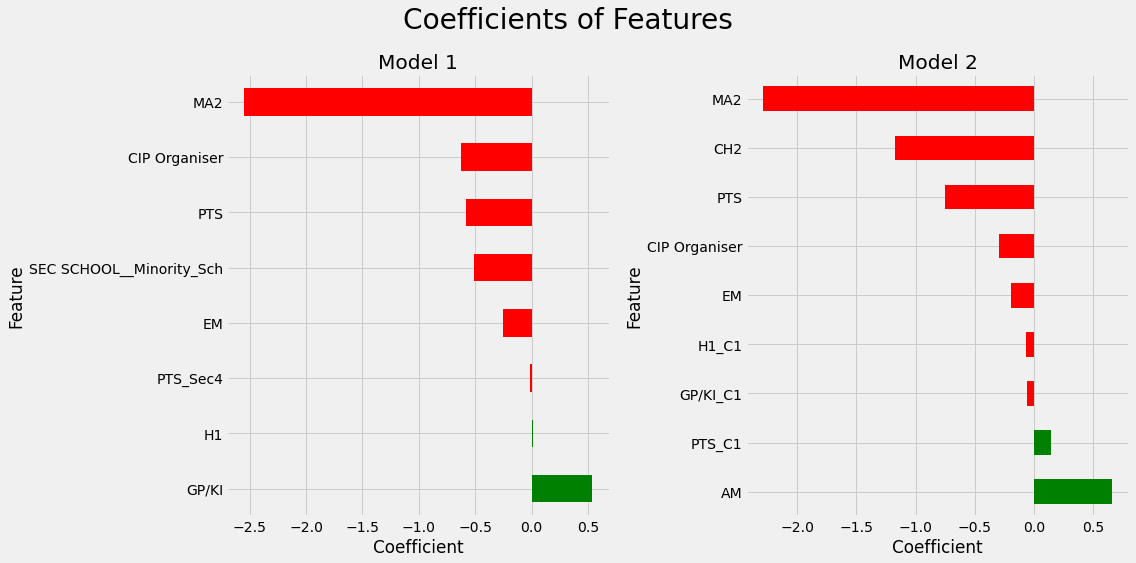

In [28]:
# top features for predicting 'ESU' grade in Logistic Regression models
coef_ESU = get_coef(logreg_4, 4, all_features) # 4 refers to 'ESU' grade

There is some consistency in the top features for predicting 'ESU' grade when using different sets of training data. 

Math Prelim Marks 'MA2' has the strongest correlation, with a value of -2.55 for Model 1 and -2.23 for Model 2. This means that keeping all other features constant, for every 1 mark increase in Math Prelim Marks, the odds ratio of getting 'ESU' in Math A level (i.e. probability of getting 'ESU' / probability of NOT getting 'ESU') is e^-2.55 = 0.078 times lower for Model 1 and e^-2.23 = 0.108 times lower for Model 2. In other words, when the Prelim Marks are higher, the student is many times less likely to get 'ESU'.

Another feature that positively impacts the Math A level grade are Prelim overall results 'PTS', with higher 'PTS' having lower probability of getting 'ESU'.

For CCA and CIP features, being a CIP organiser appears to positively impact the Math A level grade as the coefficients are negative for both models, so these students have a lower chance of getting 'ESU'. 

,Model 1,Coefficient,Model 2,Coefficient
0,MA2,1.431941,MA2,1.031045
1,PTS_C1,0.429208,PTS,0.467361
2,CH2,0.126747,MA2_C1,0.295888
3,MA2_C1,0.079817,CH2,0.123481
4,GENDER_M,0.075125,PH2,0.0591
5,PTS,0.0537,GENDER_M,0.047438
6,NaN,NaN,EC2,0.029867
60,EM,-0.058337,AM,-0.01858
61,AM,-0.099485,EM,-0.137857


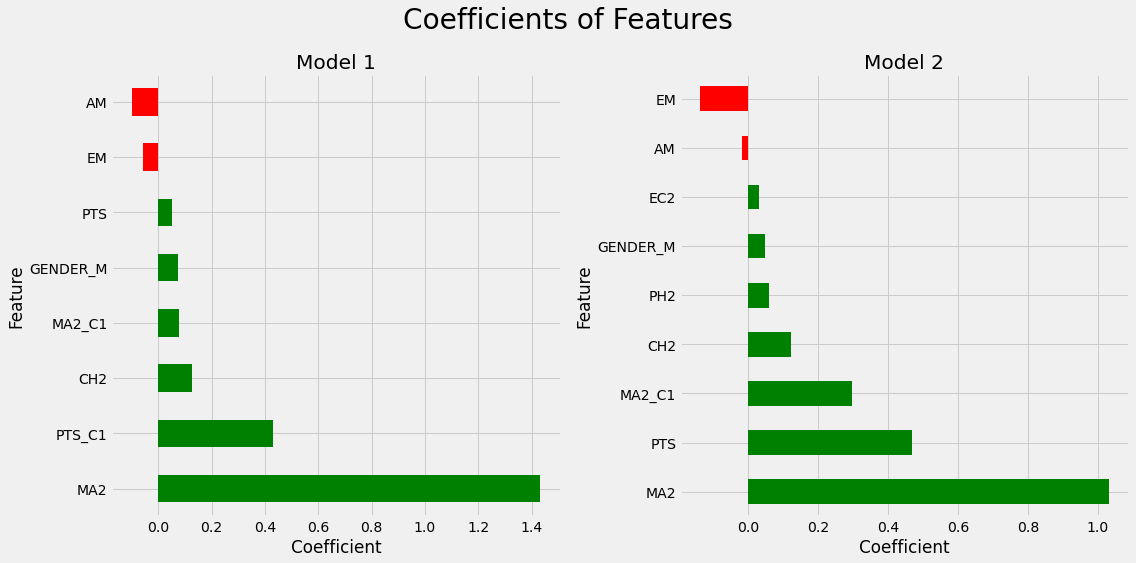

In [29]:
# top features for predicting 'A' grade in Logistic Regression models
coef_A = get_coef(logreg_4, 0, all_features) # 0 refers to 'A' grade

There is more consistency in the top features for predicting 'A' grade. 

The most important feature predicting 'ESU', Math Prelim Marks 'MA2', came out very strongly for predicting 'A' too, with a high positive coefficient of 1.43 for Model 1 and 1.03 for Model 2. This means that for every 1 mark increase in Math Prelim Marks, the odds ratio of getting 'A' in Math A level (i.e. probability of getting 'A' / probability of NOT getting 'A') is e^1.43 = 4.18 times higher for Model 1 and e^1.03 = 2.80 times higher for Model 2. In other words, when the Prelim Marks are higher, the student is many times more likely to get 'A'.

The other features are mainly related to Math results ('AM', 'EM', 'MA2_C1') or overall results ('PTS', 'PTS_C1') and are as expected. For example, 'AM' and 'EM' have negative coefficients as a higher numeric value is actually a worse grade, thus the student should be weaker in Math and be less likely to get 'A' in Math A level, but MA2_C1 is marks so a higher numeric value is actually a better result, thus the student should be stronger in Math and be more likely to get 'A'.

Some interesting insights are that 'CH2' and 'GENDER_M have positive coefficients for both models, so students who take H2 Chemistry have a higher chance of getting 'A' compared to students who do not, and similarly male students have higher chance of getting 'A' compared to female students if all other features are held constant. 

### Recommendation
For students at the boundary of grade 'A' and grade 'B', teachers may wish to focus more on the female students who do not take H2 Chemistry to help push her to an 'A' grade for Math A level.

## XG Boost Important Features
We investigate the top features for the selected XG Boost models below.

In [30]:
def get_impt_features(clf, features):
    """Get top features for models from both batches with importances > 0.3"""
    model_1, model_2 = fit_models(clf, features)
    
    impt_1 = model_1.feature_importances_
    df_1 = pd.DataFrame(zip(Features_18.columns,impt_1), 
                        columns=['Model 1','Importance']).\
                        sort_values('Importance', ascending=False).reset_index(drop=True)
    df_1 = df_1[(df_1['Importance'] > 0.03)]
    
    impt_2 = model_2.feature_importances_
    df_2 = pd.DataFrame(zip(Features_18.columns,impt_2), 
                        columns=['Model 2','Importance']).\
                        sort_values('Importance', ascending=False).reset_index(drop=True)
    df_2 = df_2[(df_2['Importance'] > 0.03)]       
    impt_df = pd.concat([df_1, df_2], axis=1)

    # rename for plotting purposes
    df_1.set_index('Model 1', drop=True, inplace=True)
    df_1.index.rename('Feature', inplace=True)
    df_2.set_index('Model 2', drop=True, inplace=True)
    df_2.index.rename('Feature', inplace=True)
    
    # plot barcharts
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Importances of Features', fontsize=28)  
    df_1['Importance'].plot(kind='barh', ax=ax[0])
    ax[0].set_title('Model 1')
    ax[0].set_xlabel('Importance')
    df_2['Importance'].plot(kind='barh', ax=ax[1])
    ax[1].set_title('Model 2')
    ax[1].set_xlabel('Importance')
    plt.tight_layout();
    
    # show dataframe of values
    display(impt_df)

,Model 1,Importance,Model 2,Importance
0,MA2,0.129767,MA2,0.121441
1,MA2_C1,0.054346,MA2_C1,0.051576
2,PTS_C1,0.043396,PTS,0.049170
3,PTS,0.036351,H1_Sci,0.045290
4,CIP Leader,0.032071,PTS_C1,0.040986
5,AM,0.031905,SEC SCHOOL__Minority_Sch,0.038659
6,H1,0.031808,EM,0.035862
7,SEC SCHOOL_SCHOOL Y,0.031279,NaN,NaN
8,CH2,0.030008,NaN,NaN


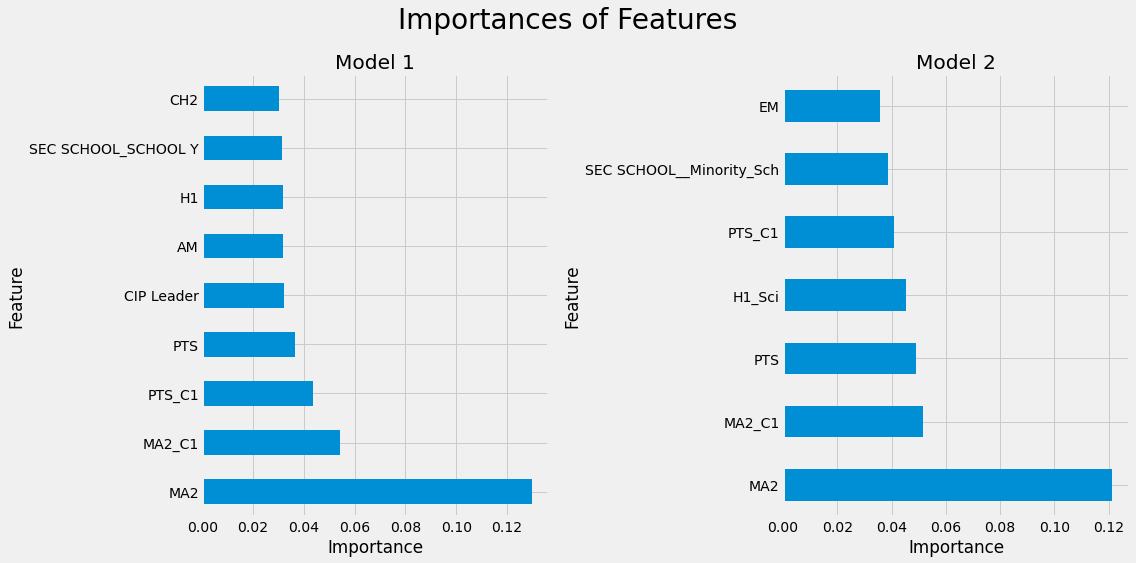

In [31]:
# top features in XG Boost models
impt_features = get_impt_features(xgb_2, all_features)

The most important features are most directly linked to Math exam scores (Math Prelim marks 'MA2' and Math C1 marks 'MA2_C1') and overall exam results (Prelim 'PTS' and C1 'PTS_C1').

# Selecting Features for Modelling
As our scores are still below the Benchmark scores, we suspect that we have included too many features resulting in an overly complex model that overfits. There is greater chance of redundancy in features and of features that are not at all related to the prediction. To mitigate this, we attempt another approach of adding features one by one according to their importances.

## Only Math Prelim Marks
This is similar to the information used by our Benchmark model. We attempt Logistic Regression with balanced class weights and adjusted class weights to see if it can perform better than Benchmark before adding other features.

In [32]:
# balanced class weights
logreg_6 = LogisticRegression(class_weight='balanced', C=100, solver='liblinear', random_state=42)
score_model(logreg_6, ['MA2'])

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7580,0.2857,0.4847,5.0
Model 1 Test Scores,0.7287,0.3750,0.4436,8.0
Model 2 Train Scores,0.7290,0.5000,0.4627,13.0
Model 2 Test Scores,0.7591,0.5714,0.5334,12.0
Mean Test Scores,0.7439,0.4732,0.4885,10.0


There is no overfitting when only one feature is used. The weighted kappa scores are marginally better than the benchmark scores (0.7287 using Model 1 vs 0.7204 using benchmark for batch 19 predictions, 0.7591 using Model 2 vs 0.7581 using benchmark for batch 18 predictions). The recall scores are not as good though, as only 8 and 12 students are identified as high-risk group requiring extra attention from teachers and we will need to give 'ESU' a higher class weight.

In [33]:
# adjusted class weights
logreg_7 = LogisticRegression(class_weight={0:1, 1:3, 2:6, 3:20, 4:600}, C=10,
                              solver='liblinear', random_state=42)
score_model(logreg_7, ['MA2'])

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7523,1.0,0.5273,27.0
Model 1 Test Scores,0.7202,1.0,0.5169,32.0
Model 2 Train Scores,0.6895,1.0,0.4785,48.0
Model 2 Test Scores,0.7564,1.0,0.5093,37.0
Mean Test Scores,0.7383,1.0,0.5131,34.5


After adjusting class weights to achieve 100% recall for ESU, the weighted kappa scores are still quite close to the benchmark scores. The number of students in the predicted 'ESU' group are also comparable at less than 40. Next we attempt to include the second most important features of Math C1 marks 'MA2_C1'.

In [34]:
# add next feature Math C1 marks
logreg_8 = LogisticRegression(class_weight={0:1, 1:3, 2:6, 3:20, 4:500},
                              C=10,
                              solver='liblinear', random_state=42)
score_model(logreg_8, ['MA2', 'MA2_C1'])

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7502,1.0,0.5663,24.0
Model 1 Test Scores,0.7177,1.0,0.5035,29.0
Model 2 Train Scores,0.7156,1.0,0.4871,42.0
Model 2 Test Scores,0.7582,1.0,0.5195,35.0
Mean Test Scores,0.7380,1.0,0.5115,32.0


The scores are very similar after adding 'MA2_C1' although the number of students in the predicted 'ESU' group dropped slightly. There appears to be minimal benefit in adding more features.

In [35]:
# add next feature Prelim Overall results 'PTS'
logreg_9 = LogisticRegression(class_weight={0:1, 1:3, 2:6, 3:20, 4:700},
                              C=5,
                              solver='liblinear', random_state=42)
score_model(logreg_9, ['MA2', 'MA2_C1', 'PTS'])

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7520,1.0,0.5771,24.0
Model 1 Test Scores,0.7130,1.0,0.5150,24.0
Model 2 Train Scores,0.7063,1.0,0.4843,43.0
Model 2 Test Scores,0.7681,1.0,0.5431,36.0
Mean Test Scores,0.7406,1.0,0.5290,30.0


With 3 features, the results are very slightly better than just 1 feature.

In [36]:
# add next feature C1 Overall results 'PTS_C1'
logreg_10 = LogisticRegression(class_weight={0:1, 1:3, 2:6, 3:20, 4:2000},
                              C=4,
                              solver='liblinear', random_state=42)
score_model(logreg_10, ['MA2', 'MA2_C1', 'PTS', 'PTS_C1'])

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Model 1 Train Scores,0.7286,1.0,0.5522,30.0
Model 1 Test Scores,0.7030,1.0,0.5266,27.0
Model 2 Train Scores,0.7150,1.0,0.5488,34.0
Model 2 Test Scores,0.7485,1.0,0.5576,36.0
Mean Test Scores,0.7258,1.0,0.5421,31.5


When we added the 4th feature 'PTS_C1', we found it difficult to find a good set of hyperparameters to improve the weighted kappa. We take logreg_9 with 3 features as our best performing model thus far.

# New Approach to Ordinal Classification
This paper [A Simple Approach to Ordinal Classification](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf) suggests a new way of transforming the multiclass target such that its ordinal nature (where there is relative rank between the classes) is taken into account, which is something that is lacking in all the classifiers we attempted earlier. We will implement this approach below to see if it improves our results.

## Binarizing y

In [37]:
# transforming target
def create_binary_y(y):
    binary_y = pd.DataFrame()
    for n in range(4):
        binary_y[n] = y.map(lambda i: 1 if i > n else 0)

    return binary_y

y_18_binary = create_binary_y(y_18['MA2'])
y_19_binary = create_binary_y(y_19['MA2'])

## Evaluating Predictions
We trial the new approach with Logistic Regression and Random Forest Classifier to see if the results improve. We focus on modelling using the batch 18 to get predictions for batch 19.

In [38]:
# function to get predictions
def pred_ord_clf(clf):    
    # get list of P(Y > n)
    pr_more_than_n = []
    for n in range(4):
        clf.fit(Features_18, y_18_binary[n])
        pr_more_than_n.append(clf.predict_proba(Features_19)[:,1])
        
    # change to numpy array
    stack = np.vstack(pr_more_than_n)
    
    # get array of P(Y = n)
    pr_equal_n = np.vstack([1 - stack[0], 
                            stack[0] - stack[1],
                            stack[1] - stack[2],
                            stack[2] - stack[3],
                           ])
    preds = np.argmax(pr_equal_n, axis=0)
    return preds

In [39]:
# Logistic Regression
get_scores(y_19_target, 
          pred_ord_clf(LogisticRegression(solver='liblinear', random_state=42)), 
          'Logistic Regression')

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Logistic Regression,0.6936,0.0,0.369,0.0


In [40]:
# Random Forest Classifier
get_scores(y_19_target, 
          pred_ord_clf(RandomForestClassifier(random_state=42)), 
          'Random Forest')

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Random Forest,0.6648,0.0,0.312,0.0


After experimenting with this new method, we find that although the weighted kappa scores are better than the corresponding model without class weights, the recall scores are worse, especially for recall for ESU as we are unable to inflate the class weight for 'ESU'. It is very important for us to identify students requiring intervention, so we abandon this new method.

# Evaluating Final Model
Although there appears to be little benefit in using any model over the Benchmark models, we nonetheless attempt to evaluate the performance of our Logistic Regression model with 3 features (logreg_9) for a comparison.

## Confusion matrices for Batch 18 and Batch 19

In [41]:
#get_confusion_matrices NOT USED due to confidentiality
def get_confusion_matrices(clf, features):
    """display confusion matrices for both batches when model is applied to other batch"""
    model_1, model_2 = fit_models(clf, features)
    pred_1_test = model_1.predict(Features_19[features])
    pred_2_test = model_2.predict(Features_18[features])
    
    print(' Model 2 on Batch 18 '.center(40, "="))
    cm_1 = pd.DataFrame(confusion_matrix(y_18_target, pred_2_test),
                        columns=['A','B','C','D','ESU'], 
                        index=['A','B','C','D','ESU'])
    cm_1.index.rename('Actual\Predicted',inplace=True)
    display(cm_1)
    print()
    print(' Model 1 on Batch 19 '.center(40, "="))
    cm_2 = pd.DataFrame(confusion_matrix(y_19_target, pred_1_test),
                        columns=['A','B','C','D','ESU'], 
                        index=['A','B','C','D','ESU'])
    cm_2.index.rename('Actual\Predicted',inplace=True)
    display(cm_2)

In [42]:
#CELL NOT RUN due to confidentiality
# # confusion matrices for Logistic Regression models
# get_confusion_matrices(logreg_9, ['MA2', 'MA2_C1', 'PTS'])

## Comparison to Benchmark

[Note confusion matrices not shown due to confidentiality.]

Comparing the confusion matrices, we see that the Logistic Regression models do better than the benchmarks in predicting 'A' grades correctly and in predicting grades correctly in general. We note also that our Logistic Regression models are more optimistic as more of the predictions end up better than the actual grade and fewer end up worse. This achieves our Objective 1 of allowing the potentially high-achieving students to be given better predicted grades to boost their university and/or scholarship applications.

|Batch|Model|Correct Predictions|Within 1 Grade|2 or More Grades Away|Better Than Actual|Worse Than Actual|
|---|---|---|---|---|---|---|
|18|Logistic Regression|82.3%|97.0%|3.0%|9.9%|7.7%|
|18|Benchmark|81.0%|97.5%|2.5%|9.1%|9.9%|
|19|Logistic Regression|78.4%|96.6%|3.4%|12.0%|9.6%|
|19|Benchmark|77.6%|95.9%|4.1%|10.3%|12.1%|

Note: Benchmark has fewer predictions generated due to students missing Math Prelim Exam and not having a Prelim Mark, which is the only feature used to generate the Benchmark predictions.

## Evaluating predictions for Batch 20

From the confusion matrices above, we get more optimistic about the advantages of using Logistic Regression over the benchmark method. We generate predictions for batch 20 by combining both batch 18 and batch 19 data to train our model.

In [43]:
# fit model to Batch 18 and Batch 19 data
logreg_9.fit(pd.concat([Features_18, Features_19])[['MA2', 'MA2_C1', 'PTS']], pd.concat([y_18, y_19])['MA2'])

# remove students without 'MA2' results in target from Features dataframe
orig_y_20 = pd.read_csv('../data_raw/20 Batch GCEA.csv', index_col='NEWID')
ind_to_del_20 = orig_y_20[orig_y_20['MA2'].isna()].index
Features_20 = Features_20.loc[~Features_20.index.isin(ind_to_del_20)]

# generate predictions
pred_20 = logreg_9.predict(Features_20[['MA2', 'MA2_C1', 'PTS']])

# get scores
get_scores(y_20_target, pred_20, 'Logistic Regression')

,Weighted Cohen's Kappa,Recall for ESU,Macro Average Recall,Number Predicted as ESU
Logistic Regression,0.7876,0.8235,0.5216,25.0


The weighted kappa is slightly higher at 0.7876 compared to the benchmark score of 0.7768, while the recall scores are worse at less than 100% for recall for ESU and slightly lower at 0.5216 for macro average recall for the Logistic Regression model compared to the benchmark score of 0.5482. This is likely due to the model only predicting 25 students in the ESU group compared to the benchmark method that highlighted 35 students.

## Comparison to Benchmark for Batch 20

[Note confusion matrices not shown due to confidentiality.]

Comparing the confusion matrices, we see that the Logistic Regression models do slightly worse than the benchmarks in predicting grades correctly. Similar to batch 18 and batch 19, we note that our Logistic Regression model is more optimistic as more of the predictions end up better than the actual grade and fewer end up worse. 

|Batch|Model|Correct Predictions|Within 1 Grade|2 or More Grades Away|Better Than Actual|Worse Than Actual|
|---|---|---|---|---|---|---|
|20|Logistic Regression|80.4%|97.3%|2.7%|12.4%|7.1%|
|20|Benchmark|80.7%|97.3%|2.7%|10.1%|9.1%|

We proceed to the [Conclusion and Recommendations](4_Conclusion_and_Recommendations.ipynb) notebook to round up the project.